<a href="https://colab.research.google.com/github/graille/ITR315-deep-telecom/blob/master/5-%20Neural%20based%20channel%20decoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural-based channel decoders


## 1. Prerequisites:  

The purpose of this part of the work is to compare the BER of both a pre-trained neural decoder and the MAP decoder for a Polar code over an AWGN channel. 

In order to develop a neural based channel decoder you will need: 

- A communication chain which implements the polar code and its MAP decoder (under python)
- A working keras environment with the proper backend Tensorflow 


## 2. Training dataset and training:  

In order to train the neural network, you need to provide it with both: 
- Input sequences: the received $y^n$
- Label sequences (or targets) : the transmitted $u^k$

In order for the neural decoder to be able to recover the original information words, i.e., $u^k$, the neural decoder needs to be trained over all possible $u^k$ and therefore, all posssible codewords $c^n$. Thus, the label sequences need to cover all possibly transmitted sequences. 

The labels can be coded in two different manners: 
- Array representation: the output of the neural network is a vector of size k, which outputs for each bit $i \in [1:k]$, a possible value 0 or 1. . 
- One hot representation: the output of the neural networ is a vector of size $2^k$ which outputs $1$ only at the index of the information word transmitted, and 0 everywhere else. 

Question: In practice, the output of a neural network is never binary, but it rather has a soft value $ \in [0:1]$. Depending on the type of the network, two possible output activation functions can be used in order to output these soft values: sigmoid or softmax. Which function should we use for either strategies? 

In this project, we will use one-hot representations. 

## 3. Testing: 
Once the neural network is trained, you can test it in the communication chain you implemented before. 

## 4. Design meta-parameters: 

The performances of the neural decoder will be strongly related to the metaparameters chosen during training. 

Try and assess the effect of the different design metaparameters: 

- Training epochs
- Number of hidden layers
- Number of neurons per layer
- Activation functions
- Training SNR 
- Optimizer 
- Loss function: mse, crossentropy 


In [6]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.communications import *
from src.utils import *

# Configuration
MODULATION = 'BPSK'
G = get_fec_matrix('POLAR_8_16')

# Initialization
transmitter = Transmitter(MODULATION, G)
receiver = Receiver(MODULATION, G)

k = transmitter.block_length
n = transmitter.block_coded_length

channel = AWGNChannel(get_bps(MODULATION), k, n)

if __name__ == '__main__':
    t = time.time()
    # receiver.block_elements contains all possible u^k (labels)
    # receiver.block_coded_elements contains all possible codewords c^n
    
    EbN0dB = 1 # in dB, SNR for the std to train with the Gaussian layer
    noise_power = calculate_noise_power(EbN0dB, 1, k, n, get_bps(MODULATION))
    noise_std = np.sqrt(1./2. * noise_power)
    print(f"Noise std : {noise_std}")
    
    # Create model
    # We are working with probability, to have sum(s_i) = 1 at the output, we use a softmax instead of a sigmoid activation function
    # Because we are using a one hot representation, we also use a categorical_crossentropy loss function
    hot_model=Sequential()
    hot_model.add(Dense(20*2**k, activation='relu', input_dim=n))
    hot_model.add(Dense(2**k, activation='softmax'))
    
    noisy_model=Sequential()
    noisy_model.add(GaussianNoise(noise_std, input_shape=(n,)))
    noisy_model.add(hot_model)
    
    noisy_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(noisy_model.summary())
    
    # Create labels for hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    print("")
    print("Start training")
    noisy_history = noisy_model.fit(
        np.array(receiver.block_coded_elements), 
        np.array(labels), 
        epochs=10**4, 
        verbose=0
    )
    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')


Noise std : 0.8912509381337456
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 16)                0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256)               1398016   
Total params: 1,398,016
Trainable params: 1,398,016
Non-trainable params: 0
_________________________________________________________________
None

Start training
Elapsed : 447.98 s


In [7]:
hot_model.save('networks/decoders/decoder_one_hot_basic.h5')

KeyError: 'acc'

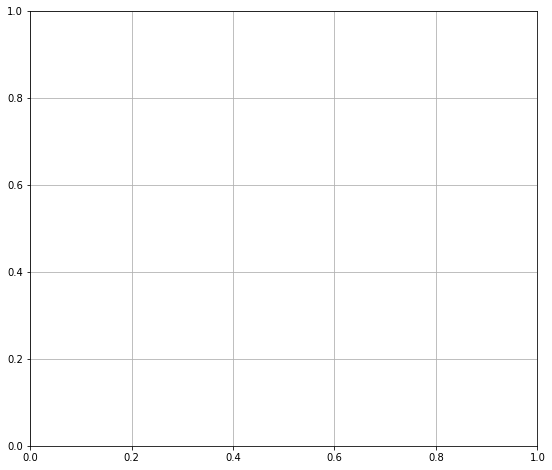

In [8]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
plt.grid()
plt.plot(noisy_history.history['acc']) # "acc" must be replaced by "accuracy" for higher version of Python
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(122)
plt.grid()
plt.plot(noisy_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.yscale('log')
# plt.subplots_adjust(wspace = 0.5)

C:\Users\Thibault\Anaconda3\envs\PythonGPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Start EbN0 1/20 [-15.0] /80 [24186.25 %] | Ended in 0.34 s
Start EbN0 2/20 [-13.79] /80 [23832.5 %] | Ended in 0.37 s
Start EbN0 3/20 [-12.58] /80 [23725.0 %] | Ended in 0.32 s
Start EbN0 4/20 [-11.37] /80 [23545.0 %] | Ended in 0.31 s
Start EbN0 5/20 [-10.16] /80 [23136.25 %] | Ended in 0.31 s
Start EbN0 6/20 [-8.95] /80 [22185.0 %] | Ended in 0.34 s
Start EbN0 7/20 [-7.74] /80 [21447.5 %] | Ended in 0.31 s
Start EbN0 8/20 [-6.53] /80 [20346.25 %] | Ended in 0.31 s
Start EbN0 9/20 [-5.32] /80 [19106.25 %] | Ended in 0.29 s
Start EbN0 10/20 [-4.11] /80 [16672.5 %] | Ended in 0.32 s
Start EbN0 11/20 [-2.89] /80 [14073.75 %] | Ended in 0.28 s
Start EbN0 12/20 [-1.68] /80 [11448.75 %] | Ended in 0.33 s
Start EbN0 13/20 [-0.47] /80 [7960.0 %] | Ended in 0.31 s
Start EbN0 14/20 [0.74] /80 [4835.0 %] | Ended in 0.31 s
Start EbN0 15/20 [1.95] /80 [2661.25 %] | Ended in 0.31 s
Start EbN0 16/20 [3.16] /80 [976.25 %] | Ended in 0.37 s
Start EbN0 17/20 [4.37] /80 [231.25 %] | Ended in 0.32 s
Star

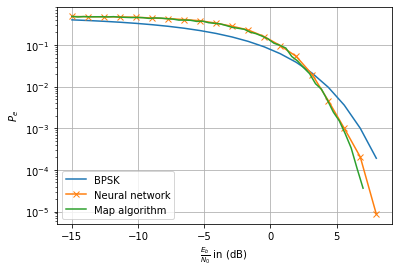

Elapsed : 84.49 s


In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import load_model

from src.communications import *
from src.utils import *

# Configuration
EbN0dBs = np.linspace(-15, 8, 20)
decoder_model = load_model(f'networks/decoders/decoder_one_hot_basic.h5')

MODULATION = 'BPSK'
G = get_fec_matrix('POLAR_8_16')

# Initialization
transmitter = Transmitter(MODULATION, G)
receiver = NetworkReceiver(transmitter.block_length, transmitter.block_coded_length, decoder_model, NeuralNetworkType.ONE_HOT)
channel = AWGNChannel(get_bps(MODULATION), transmitter.block_length, transmitter.block_coded_length)

if __name__ == '__main__':
    t = time.time()
    BER = ber_performance(
        EbN0dBs,
        get_basic_channel_fct(transmitter, channel, receiver),
        transmitter.block_length * 5000,
        80
    )
    
    [EbN0dBs_C, BER_C] = np.loadtxt('outputs/BER_G_MAP.csv', delimiter=',')
    
    # Plot results
    plt.figure()
    show_ber(MODULATION, EbN0dBs, BER)
    plt.plot(EbN0dBs_C, BER_C)
    plt.legend(['BPSK', 'Neural network', 'Map algorithm'])
    plt.show()
    
    np.savetxt('outputs/BER_G_NEURAL.csv', [np.array(EbN0dBs), np.array(BER)], delimiter=',')
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')